In [1]:
# Dependencies
import random
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)
#api_key
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import json
import time
from bs4 import BeautifulSoup as bs
import gmaps
import locale
from census import Census
c = Census('c0e1bc0567636e35afe801464f2d1acecd3485c5', year = 2017)


api_key_census = 'c0e1bc0567636e35afe801464f2d1acecd3485c5'

In [56]:
file='NYPD_Data.csv'
df_Pam=pd.read_csv(file)
df_Pam.head()
# convert CMPLNT_FR_DT to date format. 222398 rows records in file
df_Pam['CMPLNT_FR_DT'] = pd.to_datetime(df_Pam['CMPLNT_FR_DT'],errors = 'coerce') 
df_Pam.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,857927015,10.0,MANHATTAN,2019-01-29,16:37:00,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)"
1,479254687,101.0,QUEENS,2019-03-29,17:00:00,3/29/2019,17:10:00,COMPLETED,NaN,NaN,...,M,NaN,25-44,BLACK,F,1054076.0,157437.0,40.598538,-73.748560,"(40.598537593, -73.748559596)"
2,320007604,41.0,BRONX,2019-02-06,2:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)"
3,746022144,68.0,BROOKLYN,2019-01-08,22:49:00,1/8/2019,22:52:00,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,E,984439.0,166855.0,40.624663,-73.999321,"(40.624663129, -73.999320591)"
4,145366108,25.0,MANHATTAN,2019-02-11,12:07:00,NaN,NaN,COMPLETED,NaN,NaN,...,NaN,NaN,UNKNOWN,UNKNOWN,E,1002776.0,231994.0,40.803435,-73.933084,"(40.80343468, -73.93308448)"


In [3]:
# Filter for only "Felony" category
felonyDf = df_Pam[df_Pam["LAW_CAT_CD"] == 'FELONY'] 
felonyDf=felonyDf.reset_index(drop=True)
# Drop rows if CMPLNT_FR_DT does not have any value
felonyDf=felonyDf.dropna(subset = ['CMPLNT_FR_DT'])
# Limit our analysis to last 10 years - 2010 to 2019
felonyDf = felonyDf[(felonyDf['CMPLNT_FR_DT'] > '2010-01-01') & (felonyDf['CMPLNT_FR_DT'] <= '2019-09-06')]
# create new columns to store year and month to enable aggregration
felonyDf['CMPLNT_YR']=pd.DatetimeIndex(felonyDf['CMPLNT_FR_DT']).year
felonyDf['CMPLNT_Month']=pd.DatetimeIndex(felonyDf['CMPLNT_FR_DT']).month
#felonyDf.to_csv('felonyfull.csv')

felonyDf.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month
0,857927015,10.0,MANHATTAN,2019-01-29,16:37:00,1/29/2019,16:45:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)",2019,1
1,479254687,101.0,QUEENS,2019-03-29,17:00:00,3/29/2019,17:10:00,COMPLETED,NaN,NaN,...,25-44,BLACK,F,1054076.0,157437.0,40.598538,-73.748560,"(40.598537593, -73.748559596)",2019,3
2,320007604,41.0,BRONX,2019-02-06,2:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)",2019,2
3,746022144,68.0,BROOKLYN,2019-01-08,22:49:00,1/8/2019,22:52:00,COMPLETED,NaN,NaN,...,UNKNOWN,UNKNOWN,E,984439.0,166855.0,40.624663,-73.999321,"(40.624663129, -73.999320591)",2019,1
4,889702556,32.0,MANHATTAN,2019-03-11,21:40:00,NaN,NaN,COMPLETED,NaN,NaN,...,45-64,BLACK,F,999283.0,235265.0,40.812419,-73.945694,"(40.812419303, -73.945694068)",2019,3


In [4]:
zip_code_series = pd.Series()
zips = []
for x in range(len(felonyDf['Latitude'])):
    zipcode = search.by_coordinates(felonyDf.iloc[x,-5].astype(float), felonyDf.iloc[x, -4].astype(float), radius=1, returns=1)
    try:
        zipcode = zipcode[0].to_dict()
        zips.append(zipcode['zipcode'])
        #print(zips)
    except IndexError:
        #print('Data not Found')
        zips.append(0)

In [8]:
zip_code_series = pd.Series(zips)
felonyDf['Zip Code'] = zip_code_series
felony_zips = pd.DataFrame(felonyDf.groupby('Zip Code').count())
felony_zips.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month
Zip Code,,,,,,,,,,,,,,,,,,,,,
0,3341,3341,3337,3341,3341,2982,2980,3341,160,227,...,3341,3341,3341,3341,3341,3341,3341,3341,3341,3341
07077,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
10001,942,942,942,942,942,845,846,942,48,68,...,942,942,942,942,942,942,942,942,942,942
10002,954,954,953,954,954,854,855,954,36,53,...,954,954,954,954,954,954,954,954,954,954
10003,548,548,547,548,548,477,478,548,15,29,...,548,548,548,548,548,548,548,548,548,548


In [20]:
felony_zips = felony_zips.drop(0)

felony_zips = felony_zips.reset_index()
felony_zips['Zip Code'] = pd.to_numeric(felony_zips['Zip Code'])
felony_zips.head()

,index,Zip Code,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,...,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,CMPLNT_YR,CMPLNT_Month
0,1,10001,942,942,942,942,942,845,846,942,...,942,942,942,942,942,942,942,942,942,942
1,2,10002,954,954,953,954,954,854,855,954,...,954,954,954,954,954,954,954,954,954,954
2,3,10003,548,548,547,548,548,477,478,548,...,548,548,548,548,548,548,548,548,548,548
3,4,10004,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
4,5,10005,52,52,51,52,52,44,44,52,...,52,52,52,52,52,52,52,52,52,52


In [57]:
file = pd.read_csv('df_big.csv')
df_big = pd.DataFrame(file)
df_big['Zip Code'] = pd.to_numeric(df_big['Zip Code'])
df_big.head()

,Unnamed: 0,Latitude,Longitude,Zip Code,Median Household Income,Population,Median Age,Household Income,Per Capita Income,Unemployment Rate,Poverty Count,Poverty Rate
0,0,40.750742,-73.99653,10001,85221,23947.0,35.3,85221.0,86014.0,6.188135,4211.0,17.584666
1,1,40.717040,-73.98700,10002,35449,77925.0,41.8,35449.0,30677.0,8.285599,21214.0,27.223612
2,2,40.732509,-73.98935,10003,104441,55035.0,32.6,104441.0,91141.0,4.877486,3973.0,7.219042
3,3,40.706019,-74.00858,10005,154213,8680.0,30.2,154213.0,102957.0,2.664375,912.0,10.506912
4,4,40.707904,-74.01342,10006,145893,3579.0,30.7,145893.0,103279.0,1.663586,170.0,4.749930


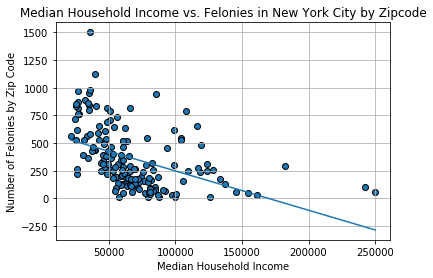

In [43]:
graph = df_big.merge(felony_zips, on = 'Zip Code')
plt.scatter(graph['Median Household Income'], graph['CMPLNT_NUM'], edgecolor = 'black')
plt.xlabel('Median Household Income')
plt.ylabel('Number of Felonies by Zip Code')
plt.title('Median Household Income vs. Felonies in New York City by Zipcode')
plt.grid()

plt.plot(np.unique(graph['Median Household Income']), np.poly1d(np.polyfit(graph['Median Household Income'], graph['CMPLNT_NUM'], 1))(np.unique(graph['Median Household Income'])))




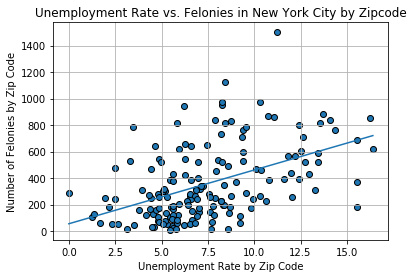

In [42]:
plt.scatter(graph['Unemployment Rate'], graph['CMPLNT_NUM'], edgecolor = 'black')
plt.xlabel('Unemployment Rate by Zip Code')
plt.ylabel('Number of Felonies by Zip Code')
plt.title('Unemployment Rate vs. Felonies in New York City by Zipcode')
plt.grid()

plt.plot(np.unique(graph['Unemployment Rate']), np.poly1d(np.polyfit(graph['Unemployment Rate'], graph['CMPLNT_NUM'], 1))(np.unique(graph['Unemployment Rate'])))



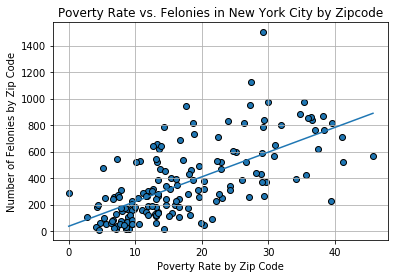

In [41]:
plt.scatter(graph['Poverty Rate'], graph['CMPLNT_NUM'], edgecolor = 'black')
plt.xlabel('Poverty Rate by Zip Code')
plt.ylabel('Number of Felonies by Zip Code')
plt.title('Poverty Rate vs. Felonies in New York City by Zipcode')
plt.grid()
plt.plot(np.unique(graph['Poverty Rate']), np.poly1d(np.polyfit(graph['Poverty Rate'], graph['CMPLNT_NUM'], 1))(np.unique(graph['Poverty Rate'])))

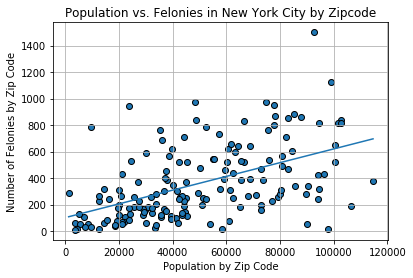

In [40]:
plt.scatter(graph['Population'], graph['CMPLNT_NUM'], edgecolor = 'black')
plt.xlabel('Population by Zip Code')
plt.ylabel('Number of Felonies by Zip Code')
plt.title('Population vs. Felonies in New York City by Zipcode')
plt.grid()
plt.plot(np.unique(graph['Population']), np.poly1d(np.polyfit(graph['Population'], graph['CMPLNT_NUM'], 1))(np.unique(graph['Population'])))




In [53]:
df = graph[['Zip Code','Median Household Income','Unemployment Rate','Poverty Rate','Population','CMPLNT_NUM']]

In [55]:
df.to_csv('df.csv')

In [54]:
df.head()

,Zip Code,Median Household Income,Unemployment Rate,Poverty Rate,Population,CMPLNT_NUM
0,10001,85221,6.188135,17.584666,23947.0,942
1,10002,35449,8.285599,27.223612,77925.0,954
2,10003,104441,4.877486,7.219042,55035.0,548
3,10005,154213,2.664375,10.506912,8680.0,52
4,10006,145893,1.663586,4.749930,3579.0,58
